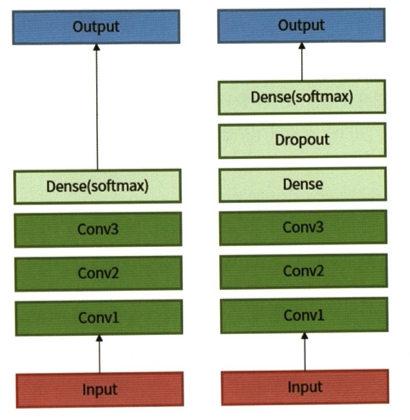

In [1]:
from IPython.display import  Image
Image('/content/drive/MyDrive/edu.kenshi/2021/품질재단/DL/new_res/전이학습-2.png')

# 기존 모델의 가중치 그대로 사용(포함되는 부분까지)
# 출력 방향으로 단순히 분류만 넣는것이 아니라, 깊이를 좀더 넣어서 출력층까지 수렴하게 구성

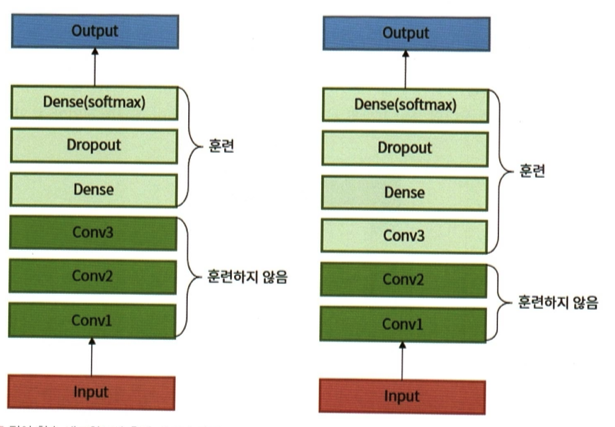

In [2]:
Image('/content/drive/MyDrive/edu.kenshi/2021/품질재단/DL/new_res/전이학습-3.png')

In [ ]:
import tensorflow as tf
tf.__version__

'2.6.0'

- 기존 15번 코드에서 데이터 준비, 확인 부분 카피해서 구성 (실습)

# 데이터 준비

In [ ]:
# 훈련 데이터의 실제 정딥
tf.keras.utils.get_file('/content/labels.csv', 'http://bit.ly/2GDxsYS')
# 경쟁시 제출하는 답안 양식
tf.keras.utils.get_file('/content/sample_submission.csv', 'http://bit.ly/2GGnMNd')
# 훈련 데이터 
tf.keras.utils.get_file('/content/train.zip', 'http://bit.ly/31nIyel')
# 테스트 데이터
tf.keras.utils.get_file('/content/test.zip', 'http://bit.ly/2GHEsnO')

362856448/362841195 [==============================] - 6s 0us/step


'/content/test.zip'

In [ ]:
!unzip train.zip
!unzip test.zip

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
  inflating: test/82ddade069436304c8b98fe2b3c4f5ec.jpg  
  inflating: test/82e41a906dbd9ec362a3d49cf6bbe645.jpg  
  inflating: test/82e5e34cc18b267ef7057cc92de8b44b.jpg  
  inflating: test/82e64f28df4fff22beb11e9a1e413212.jpg  
  inflating: test/82ec6bdf968a14923340179515ce5546.jpg  
  inflating: test/82ee3ee4dc01b33203a049c6c3338034.jpg  
  inflating: test/82f07a63a1f03ff9d8e0f4a8458caa93.jpg  
  inflating: test/82f5fb0bdaff30a4a3374e2d9915856c.jpg  
  inflating: test/82fbff1bd375474e3d4ec5cbfde3f9f0.jpg  
  inflating: test/8301c772feb7f4068473f0157ae58f9b.jpg  
  inflating: test/8307be57a9d76c1584e16801a39cb1dc.jpg  
  inflating: test/831a38bd2cfa0a093967d5b6c1ac09dc.jpg  
  inflating: test/831ef824af939f9754e3593638933b64.jpg  
  inflating: test/8322f53b29325419ef3bcf7cf10d7172.jpg  
  inflating: test/83233e2774e116ef34a04c53dd00a282.jpg  
  inflating: test/832cae23410e741ecd2014b3818ed7c4.jpg  
  inflating: test/833f90a3652b06607b55bd25c8d97457.j

## 정답 데이터 전처리

In [ ]:
import pandas as pd
import numpy as np
label_text = pd.read_csv('/content/labels.csv')
uni_Y      = label_text['breed'].unique().tolist()
train_Y    = [ uni_Y.index( name )  for name in label_text['breed'] ]
train_Y    = np.array( train_Y )

## 훈련 데이터 전처리

In [ ]:
import cv2
train_X = []
for i in range( 1000 ):  
  fName = label_text['id'][i]
  img   = cv2.imread(f'/content/train/{ fName }.jpg')  
  img   = cv2.resize(img, dsize=(224, 224))  
  img   = img / 255.0  
  train_X.append( img )
train_X = np.array( train_X )

# 전이학습

## 사전 학습된 모델 가져오기

In [ ]:
from tensorflow.keras.applications import MobileNetV2
mobilev2 = MobileNetV2()
len( mobilev2.layers )

14548992/14536120 [==============================] - 1s 0us/step


156

## 로드된 모델의 신경망 구성 확인

In [ ]:
mobilev2.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 112, 112, 32) 0           bn_Conv1[0][0]                   
_______________________________________________________________________________

- 모델 개선(적용) 방안
- case 1 : 기존 모델에서 맨뒤부터 20개 까지는 학습을 통해 파라미터를 변경, 맨 처음부터 마지막 20개까지는 유지(파라미터, 가중치, 편향) : 20는 설정
- case 2 : 뒷부분에 신경망을 추가할것이다
  - 앞 케이스 : 1280 -> 120 수렴
  - 앞 케이스 : 1280 -> 520 -> 120 수렴 (예시)
- 실험을 위해서 조건을 한가지만 조정
  - case 1 적용

In [ ]:
# 기존 모델에 분류하는 부분만 교체 (1000개 분류 -> 120개 분류 교체)
x           = mobilev2.layers[-2].output
predictions = tf.keras.layers.Dense( 120, activation='softmax')( x )
model       = tf.keras.Model( inputs=mobilev2.input, outputs=predictions )

In [ ]:
# case 1 적용
CHANHE_LAYERS = 20

# 앞에서부터 마지막 20개 층까지는 파라미터 유지 => 훈련해도 반영 않됨
for layer in model.layers[ : -CHANHE_LAYERS ]:
  # 기존 가중치, 편향등이 유지
  layer.trainable= False

# 맨뒤에서부터 마지막 20개는 신규 학습으로 파라미터 튜닝 => 훈련 하면 반영됨
# 이 20개에 대해서 가중치, 편향등 파라미터값을 초기화 하지 않았다
# 기존에 학습된 값을 가져가면서, 미세조정을 진행 -> 이런 루틴이 적요되는 층수는 20층이고, 
# 조정 가능하다!!
for layer in model.layers[ -CHANHE_LAYERS : ]:
  # 기존 가중치, 편향등이 미세조정
  layer.trainable= True

- 기존 모델
  - Trainable params: 3,504,872
- 신규 모델
  - Trainable params: 1,204,280
  - 156층에서 20층 제외 136층에 대한 파라미터를 훈련 불가로 설정한 결과
  - 훈련후 미세조종될 파라미터의 개수가 현저하게 줄었다

In [ ]:
# 컴파일 
model.compile( optimizer='sgd', loss='sparse_categorical_crossentropy', metrics=['accuracy'] )
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 112, 112, 32) 0           bn_Conv1[0][0]                   
______________________________________________________________________________________________

In [ ]:
# 학습
with tf.device('/device:GPU:0'):
  hist = model.fit( train_X, train_Y, epochs=10, validation_split=0.25, batch_size=32 )

Epoch 1/10
24/24 [==============================] - 36s 209ms/step - loss: 4.8381 - accuracy: 0.0267 - val_loss: 4.5254 - val_accuracy: 0.0600
Epoch 2/10
24/24 [==============================] - 3s 121ms/step - loss: 3.7730 - accuracy: 0.2080 - val_loss: 4.1138 - val_accuracy: 0.1040
Epoch 3/10
24/24 [==============================] - 3s 121ms/step - loss: 2.8925 - accuracy: 0.5093 - val_loss: 3.7715 - val_accuracy: 0.1760
Epoch 4/10
24/24 [==============================] - 3s 122ms/step - loss: 2.2140 - accuracy: 0.6960 - val_loss: 3.4653 - val_accuracy: 0.2200
Epoch 5/10
24/24 [==============================] - 3s 121ms/step - loss: 1.6894 - accuracy: 0.8307 - val_loss: 3.2337 - val_accuracy: 0.2720
Epoch 6/10
24/24 [==============================] - 3s 121ms/step - loss: 1.3031 - accuracy: 0.9027 - val_loss: 3.0559 - val_accuracy: 0.3080
Epoch 7/10
24/24 [==============================] - 3s 123ms/step - loss: 0.9992 - accuracy: 0.9440 - val_loss: 2.9409 - val_accuracy: 0.3040
Epoch

NameError: ignored

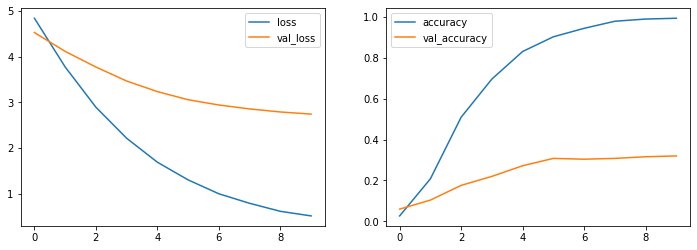

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,4))

plt.subplot( 1, 2, 1)
plt.plot( hist.history['loss'], label='loss' )
plt.plot( hist.history['val_loss'], label='val_loss' )

plt.legend()

plt.subplot( 1, 2, 2)
plt.plot( hist.history['accuracy'], label='accuracy' )
plt.plot( hist.history['val_accuracy'] , label='val_accuracy')

plt.legend()

plt.show()
# 손실은 0에 수렴하고, 정확도는 100에 수렴하는 전형적인 형태로 훈련되었다